In [37]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
%matplotlib inline
from pathlib import Path
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

/kaggle/input/flightdelay/DelayedFlights.csv


Importing the data

In [38]:
df = pd.read_csv('/kaggle/input/flightdelay/DelayedFlights.csv')

Viewing the data

In [39]:
df.head()

,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,...,4.0,8.0,0,N,0,NaN,NaN,NaN,NaN,NaN
1,1,2008,1,3,4,754.0,735,1002.0,1000,WN,...,5.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN
2,2,2008,1,3,4,628.0,620,804.0,750,WN,...,3.0,17.0,0,N,0,NaN,NaN,NaN,NaN,NaN
3,4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,...,3.0,10.0,0,N,0,2.0,0.0,0.0,0.0,32.0
4,5,2008,1,3,4,1940.0,1915,2121.0,2110,WN,...,4.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1936758 entries, 0 to 1936757
Data columns (total 30 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Unnamed: 0         int64  
 1   Year               int64  
 2   Month              int64  
 3   DayofMonth         int64  
 4   DayOfWeek          int64  
 5   DepTime            float64
 6   CRSDepTime         int64  
 7   ArrTime            float64
 8   CRSArrTime         int64  
 9   UniqueCarrier      object 
 10  FlightNum          int64  
 11  TailNum            object 
 12  ActualElapsedTime  float64
 13  CRSElapsedTime     float64
 14  AirTime            float64
 15  ArrDelay           float64
 16  DepDelay           float64
 17  Origin             object 
 18  Dest               object 
 19  Distance           int64  
 20  TaxiIn             float64
 21  TaxiOut            float64
 22  Cancelled          int64  
 23  CancellationCode   object 
 24  Diverted           int64  
 25  CarrierDelay      

Converting Depdate to datetime format

In [41]:
df['DepDate'] = pd.to_datetime(df.Year*10000+df.Month*100+df.DayofMonth,format='%Y%m%d')

Making a new feature for Status, this was mainly used for the EDA, but thought i'd also use it here. where status 0 is on time, status 1 is slightly delayed and status 2 is heavily delayed
Also dropping columns that wont be needed. The model could probably have dropped a couple more.

In [42]:
for dataset in df:
    df.loc[df['ArrDelay'] <= 15, 'Status'] = 0
    df.loc[df['ArrDelay'] >= 15, 'Status'] = 1
    df.loc[df['ArrDelay'] >= 60, 'Status'] = 2
    df.loc[df['Diverted'] == 1, 'Status'] = 3
    df.loc[df['Cancelled'] == 1, 'Status'] = 4

columns_to_drop = ["Unnamed: 0", "Year", "DayofMonth", "DepTime", "DepDelay", "ArrTime", "CRSArrTime", "ActualElapsedTime", "Diverted", "Cancelled", "Distance", "FlightNum", "TailNum"]
df = df.drop(columns=columns_to_drop)

Making a feature for the season of the flight, also a feature for showing if its the weekend or not.

In [43]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'
df['Season'] = df['Month'].apply(get_season)

df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x in [6,7] else 0)

In [44]:
df.value_counts('Status')

Status
1.0    799660
0.0    680883
2.0    447828
3.0      7754
4.0       633
Name: count, dtype: int64

Plotting the distribution

<function matplotlib.pyplot.show(close=None, block=None)>

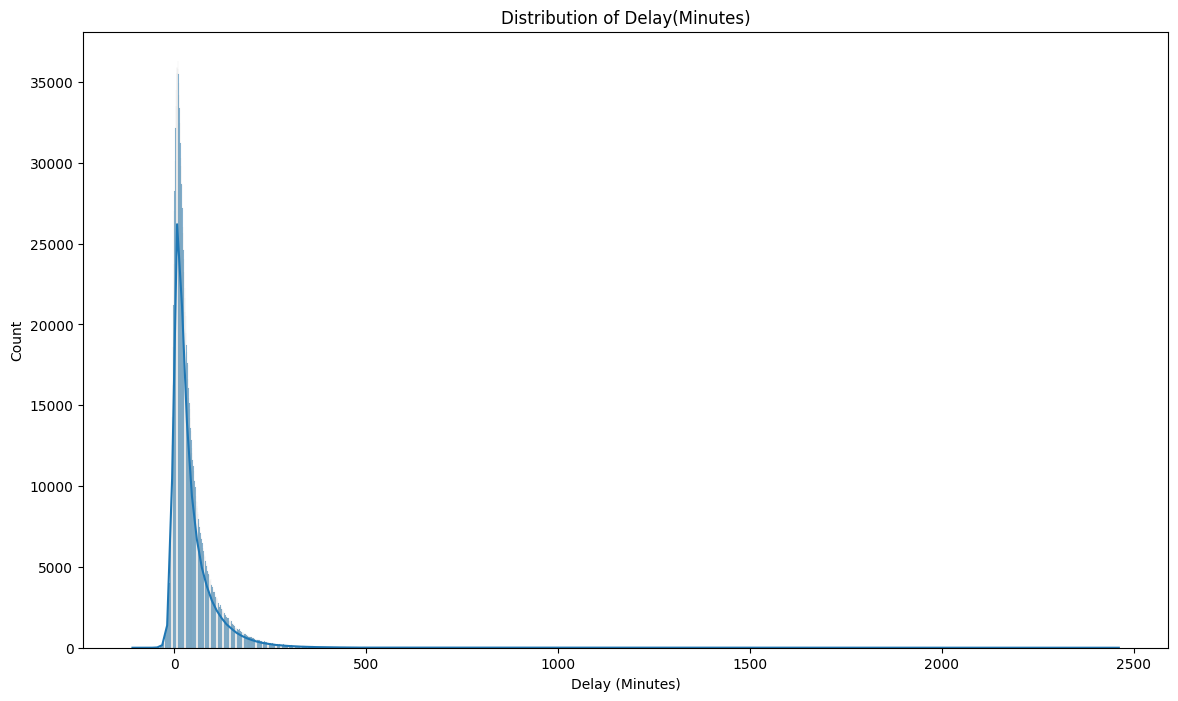

In [45]:
plt.figure(figsize=(14,8))
sns.histplot(df.ArrDelay, kde=True)
plt.xlabel('Delay (Minutes)')
plt.ylabel('Count')
plt.title('Distribution of Delay(Minutes)')
plt.show

In [46]:
Delayedflights = df[(df.Status >= 1) &(df.Status < 3)]

Plotting the average delays per month, and number of minutes delay per month

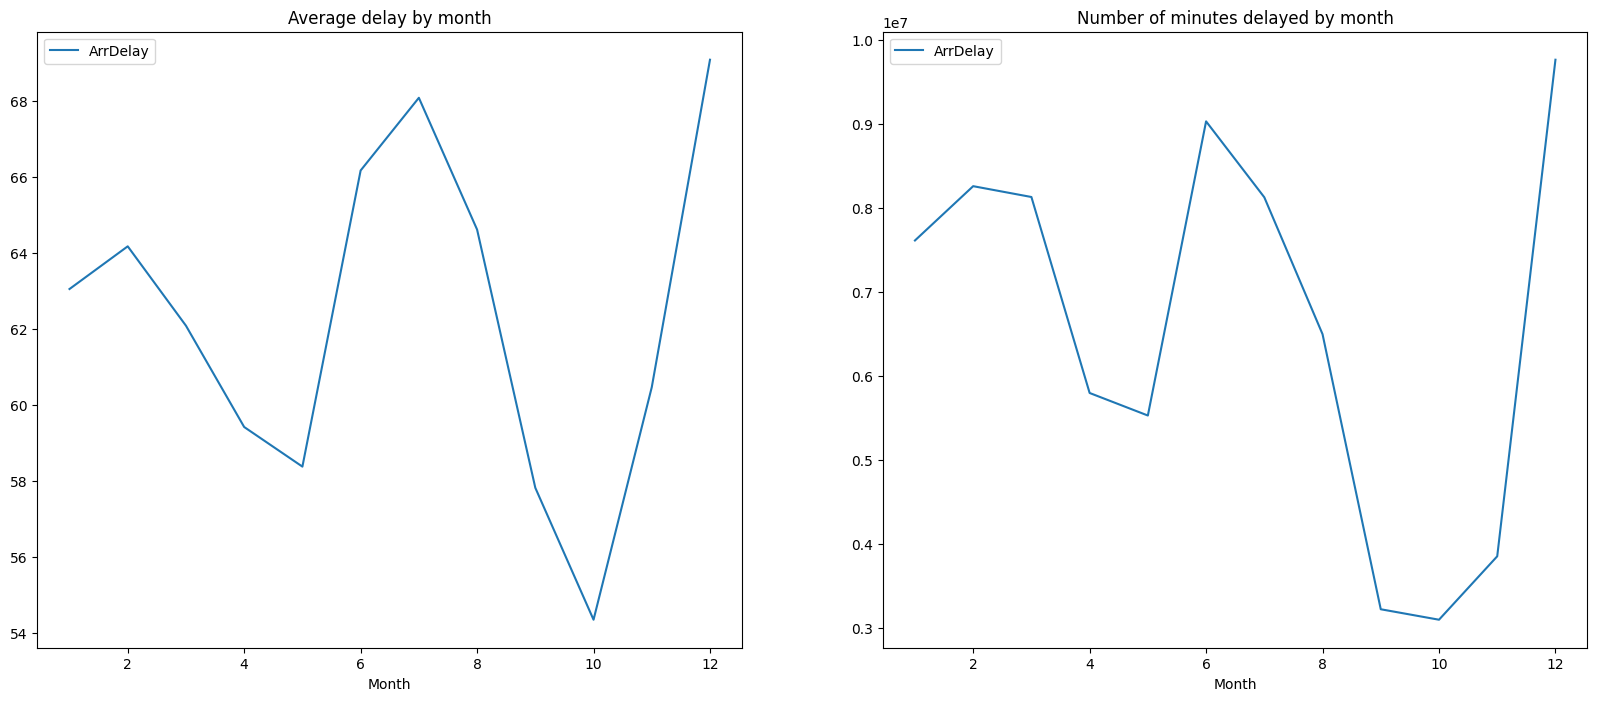

In [47]:
f,ax=plt.subplots(1,2,figsize=(20,8))
Delayedflights[['Month', 'ArrDelay']].groupby(['Month']).mean().plot(ax=ax[0])
ax[0].set_title('Average delay by month')
Delayedflights[['Month', 'ArrDelay']].groupby(['Month']).sum().plot(ax=ax[1])
ax[1].set_title('Number of minutes delayed by month')
plt.show()

Profile report for further investigation of the data, commented out for time sake.

In [48]:
#from ydata_profiling import ProfileReport

In [49]:
#ProfileReport(df)

In [50]:
df.head()

,Month,DayOfWeek,CRSDepTime,UniqueCarrier,CRSElapsedTime,AirTime,ArrDelay,Origin,Dest,TaxiIn,...,CancellationCode,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,DepDate,Status,Season,IsWeekend
0,1,4,1955,WN,150.0,116.0,-14.0,IAD,TPA,4.0,...,N,NaN,NaN,NaN,NaN,NaN,2008-01-03,0.0,Winter,0
1,1,4,735,WN,145.0,113.0,2.0,IAD,TPA,5.0,...,N,NaN,NaN,NaN,NaN,NaN,2008-01-03,0.0,Winter,0
2,1,4,620,WN,90.0,76.0,14.0,IND,BWI,3.0,...,N,NaN,NaN,NaN,NaN,NaN,2008-01-03,0.0,Winter,0
3,1,4,1755,WN,90.0,77.0,34.0,IND,BWI,3.0,...,N,2.0,0.0,0.0,0.0,32.0,2008-01-03,1.0,Winter,0
4,1,4,1915,WN,115.0,87.0,11.0,IND,JAX,4.0,...,N,NaN,NaN,NaN,NaN,NaN,2008-01-03,0.0,Winter,0


Hot coding the season so that its numbers

In [51]:
one_hot = pd.get_dummies(df['Season'])
df = df.join(one_hot)

Dropping even more columns as these were troublesome to include as hot encoding would create hundreds of columns.

In [52]:
df.drop(['UniqueCarrier', 'Origin', 'Dest', 'CancellationCode', 'Season', 'DepDate'], axis=1, inplace=True)

Filling the NaN's with 0.

In [53]:
columns_with_nans = ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
df[columns_with_nans] = df[columns_with_nans].fillna(0)

In [54]:
df.drop_duplicates()

,Month,DayOfWeek,CRSDepTime,CRSElapsedTime,AirTime,ArrDelay,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Status,IsWeekend,Fall,Spring,Summer,Winter
0,1,4,1955,150.0,116.0,-14.0,4.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0,False,False,False,True
1,1,4,735,145.0,113.0,2.0,5.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0,False,False,False,True
2,1,4,620,90.0,76.0,14.0,3.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0,False,False,False,True
3,1,4,1755,90.0,77.0,34.0,3.0,10.0,2.0,0.0,0.0,0.0,32.0,1.0,0,False,False,False,True
4,1,4,1915,115.0,87.0,11.0,4.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936753,12,6,1220,152.0,120.0,25.0,9.0,18.0,3.0,0.0,0.0,0.0,22.0,1.0,1,False,False,False,True
1936754,12,6,600,109.0,78.0,75.0,15.0,34.0,0.0,57.0,18.0,0.0,0.0,2.0,1,False,False,False,True
1936755,12,6,847,143.0,122.0,99.0,8.0,32.0,1.0,0.0,19.0,0.0,79.0,2.0,1,False,False,False,True
1936756,12,6,1240,117.0,89.0,9.0,13.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,1,False,False,False,True


Dropping a couple with NaN as these were usually Diversions etc.

In [55]:
df = df.dropna(subset=['CRSElapsedTime', 'AirTime', 'ArrDelay', 'TaxiIn', 'TaxiOut'])

Creating my f:X→y
 


In [56]:
X = df.drop('ArrDelay', axis=1)
y = df['ArrDelay']

In [57]:
X.head()

,Month,DayOfWeek,CRSDepTime,CRSElapsedTime,AirTime,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Status,IsWeekend,Fall,Spring,Summer,Winter
0,1,4,1955,150.0,116.0,4.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0,False,False,False,True
1,1,4,735,145.0,113.0,5.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0,False,False,False,True
2,1,4,620,90.0,76.0,3.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0,False,False,False,True
3,1,4,1755,90.0,77.0,3.0,10.0,2.0,0.0,0.0,0.0,32.0,1.0,0,False,False,False,True
4,1,4,1915,115.0,87.0,4.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0,False,False,False,True


In [58]:
y.head()

0   -14.0
1     2.0
2    14.0
3    34.0
4    11.0
Name: ArrDelay, dtype: float64

Making my train test datas

In [59]:
from sklearn.model_selection import train_test_split

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [61]:
len(X_train), len(X_test)

(1542696, 385675)

Installing pycaret for the use of modeling

In [62]:
!pip install pycaret

In [63]:
from sklearn.linear_model import LinearRegression

In [64]:
from sklearn.preprocessing import StandardScaler

Scaling the train and test sets.

In [65]:
std = StandardScaler()
X_train_std = std.fit_transform(X_train)
X_test_std = std.transform(X_test)

Making a quick LinearRegression model

In [66]:
lr = LinearRegression()
lr.fit(X_train_std, y_train)

LinearRegression()

plotting the linear regression, looks pretty good :)

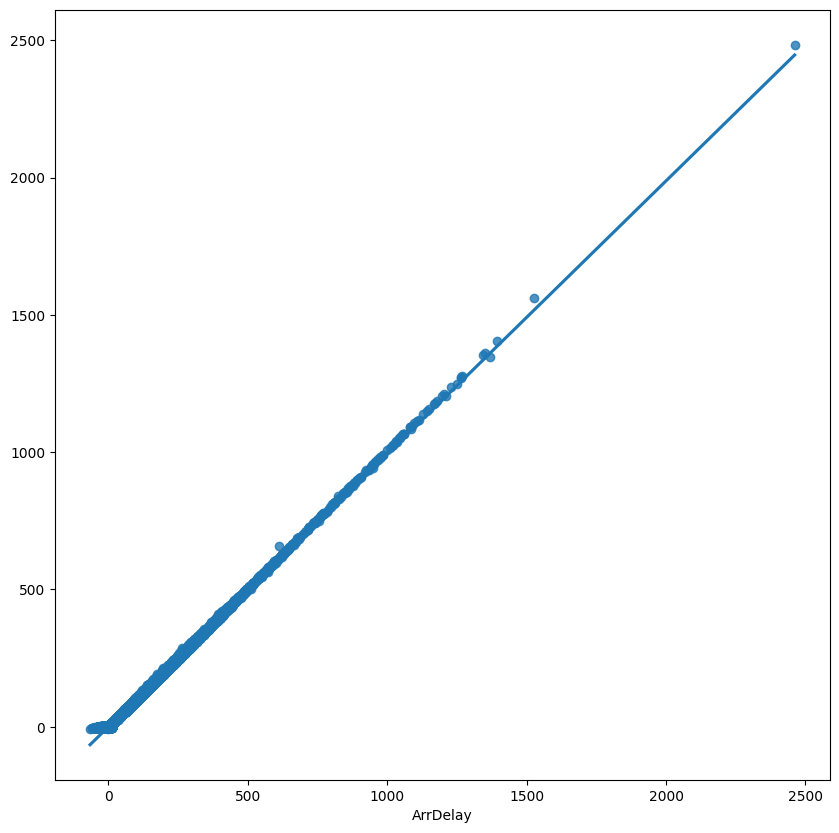

In [67]:
plt.figure(figsize=(10,10))
sns.regplot(x=y_test, y = lr.predict(X_test_std))
plt.show()

In [68]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mean_absolute_error(y_test, lr.predict(X_test_std))
mean_squared_error(y_test, lr.predict(X_test_std), squared=True)
mean_squared_error(y_test, lr.predict(X_test_std), squared=False)
r2_score(y_test, lr.predict(X_test_std))

0.9937108698097125

letting pycaret figure out the best one. compare_models() was supposed to be used, but it froze on 51% so i did it manually instead.

In [69]:
%%time
from pycaret.regression import *
experiment = setup(data=df, target='ArrDelay')

,Description,Value
0,Session id,5380
1,Target,ArrDelay
2,Target type,Regression
3,Original data shape,"(1928371, 19)"
4,Transformed data shape,"(1928371, 19)"
5,Transformed train set shape,"(1349859, 19)"
6,Transformed test set shape,"(578512, 19)"
7,Numeric features,14
8,Preprocess,True
9,Imputation type,simple


CPU times: user 28.2 s, sys: 2.22 s, total: 30.4 s
Wall time: 31.8 s


In [70]:
lr_model = create_model('lr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.9780,20.3298,4.5089,0.9937,0.5810,0.3494
1,2.9785,20.4922,4.5268,0.9935,0.5808,0.3488
2,2.9836,20.6659,4.5460,0.9935,0.5806,0.3498
3,2.9648,20.1858,4.4929,0.9937,0.5765,0.3478
4,2.9678,20.3979,4.5164,0.9937,0.5806,0.3484
5,2.9698,20.3286,4.5087,0.9937,0.5788,0.3498
6,2.9795,20.6109,4.5399,0.9936,0.5811,0.3495
7,2.9800,20.4756,4.5250,0.9938,0.5786,0.3496
8,2.9681,20.1660,4.4907,0.9939,0.5771,0.3493


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [71]:
dt_model = create_model('dt')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.4210,30.9007,5.5588,0.9905,0.5348,0.4936
1,2.4196,31.3291,5.5972,0.9901,0.5381,0.4926
2,2.4303,29.8632,5.4647,0.9906,0.5397,0.4947
3,2.4001,28.7569,5.3625,0.9910,0.5306,0.4885
4,2.4163,36.4674,6.0388,0.9887,0.5334,0.4891
5,2.4191,31.5929,5.6208,0.9903,0.5354,0.4941
6,2.4364,39.4950,6.2845,0.9877,0.5375,0.4921
7,2.4526,40.9541,6.3995,0.9875,0.5377,0.4930
8,2.4222,30.3155,5.5059,0.9908,0.5354,0.4921


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating the models.

In [72]:
evaluate_model(lr_model)

ImportError: cannot import name 'prod' from 'scipy._lib._util' (/opt/conda/lib/python3.10/site-packages/scipy/_lib/_util.py)

In [73]:
evaluate_model(dt_model)

ImportError: cannot import name 'prod' from 'scipy._lib._util' (/opt/conda/lib/python3.10/site-packages/scipy/_lib/_util.py)

Tuning the LinearRegression model to see if it can be improved.

In [74]:
tuned_lr_model = tune_model(lr_model, optimize='R2')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.9780,20.3298,4.5089,0.9937,0.5810,0.3494
1,2.9785,20.4922,4.5268,0.9935,0.5808,0.3488
2,2.9836,20.6659,4.5460,0.9935,0.5806,0.3498
3,2.9648,20.1858,4.4929,0.9937,0.5765,0.3478
4,2.9678,20.3979,4.5164,0.9937,0.5806,0.3484
5,2.9698,20.3286,4.5087,0.9937,0.5788,0.3498
6,2.9795,20.6109,4.5399,0.9936,0.5811,0.3495
7,2.9800,20.4756,4.5250,0.9938,0.5786,0.3496
8,2.9681,20.1660,4.4907,0.9939,0.5771,0.3493


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 2 candidates, totalling 20 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [75]:
final_model = finalize_model(tuned_lr_model)

Saving the  model.

In [76]:
save_model(final_model, 'finalized_lr_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['Month', 'DayOfWeek', 'CRSDepTime',
                                              'CRSElapsedTime', 'AirTime',
                                              'TaxiIn', 'TaxiOut',
                                              'CarrierDelay', 'WeatherDelay',
                                              'NASDelay', 'SecurityDelay',
                                              'LateAircraftDelay', 'Status',
                                              'IsWeekend'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('actual_estimator', LinearRegression(n_jobs=-1))]),
 'finalized_lr_model.pkl')

When i published this to Gradio, i used scikit libraries instead of pycaret because of technical difficulties when deploying.